In [82]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, InputLayer, Flatten, Input, Conv2D, MaxPool2D, Dropout, BatchNormalization, Layer, Rescaling, Resizing, RandomRotation, RandomFlip, RandomContrast
from tensorflow.keras.losses import BinaryCrossentropy, CategoricalCrossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import BinaryAccuracy, Precision, Recall, AUC, FalseNegatives, FalsePositives, TruePositives, TrueNegatives
from tensorflow.keras.metrics import CategoricalAccuracy, TopKCategoricalAccuracy
from tensorflow.keras.callbacks import Callback, CSVLogger, EarlyStopping, LearningRateScheduler
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.regularizers import L2
import sklearn
from sklearn.metrics import confusion_matrix, roc_curve
import seaborn as sns
import cv2
import tensorflow_probability as tfp


In [15]:
train_dir = "content/dataset/Emotions Dataset/Emotions Dataset/train"
validation_dir = "content/dataset/Emotions Dataset/Emotions Dataset/test"
class_names = ["angry", "happy", "sad"]
IM_SIZE = 256
CONFIGURATION = {
    'BATCH_SIZE': 32,
    "IM_SIZE": 256,
    "LEARNING_RATE": 0.0001,
    "N_EPOCHS": 10,
    "DROPOUT_RATE": 0.0,
    "REGULARIZATION_RATE": 0.0,
    "N_FILTERS": 6,
    "KERNEl_SIZE": 3,
    "N_STRIDES": 1,
    "POOL_SIZE": 2,
    "N_DENSE_1": 100,
    "N_DENSE_2": 10,
    "NUM_CLASSES": 3,
}

In [3]:
train_dataset = image_dataset_from_directory(
    train_dir,
    labels='inferred',
    label_mode='categorical',
    class_names=class_names,
    color_mode='rgb',
    batch_size=CONFIGURATION['BATCH_SIZE'],
    image_size=(256, 256),
    shuffle=True,
    seed=99,    
)

Found 6799 files belonging to 3 classes.


In [4]:
val_dataset = image_dataset_from_directory(
    validation_dir,
    labels='inferred',
    label_mode='categorical',
    class_names=class_names,
    color_mode='rgb',
    batch_size=CONFIGURATION['BATCH_SIZE'],
    image_size=(CONFIGURATION['IM_SIZE'], CONFIGURATION['IM_SIZE']),
    shuffle=True,
    seed=99,    
)

Found 2278 files belonging to 3 classes.


In [5]:
for i in val_dataset.take(1):
    print(i)

(<tf.Tensor: shape=(32, 256, 256, 3), dtype=float32, numpy=
array([[[[ 20.        ,  20.        ,  20.        ],
         [ 19.1875    ,  19.1875    ,  19.1875    ],
         [ 19.        ,  19.        ,  19.        ],
         ...,
         [ 29.125     ,  29.125     ,  29.125     ],
         [ 25.        ,  25.        ,  25.        ],
         [ 25.        ,  25.        ,  25.        ]],

        [[ 20.        ,  20.        ,  20.        ],
         [ 19.847656  ,  19.847656  ,  19.847656  ],
         [ 19.8125    ,  19.8125    ,  19.8125    ],
         ...,
         [ 28.820312  ,  28.820312  ,  28.820312  ],
         [ 25.660156  ,  25.660156  ,  25.660156  ],
         [ 25.        ,  25.        ,  25.        ]],

        [[ 20.6875    ,  20.6875    ,  20.6875    ],
         [ 21.246094  ,  21.246094  ,  21.246094  ],
         [ 21.847656  ,  21.847656  ,  21.847656  ],
         ...,
         [ 25.3125    ,  25.3125    ,  25.3125    ],
         [ 22.375     ,  22.375     ,  22.375 

2024-07-25 09:36:44.037808: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


### DATASET VISUALIZATION

2024-07-25 09:36:51.902502: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


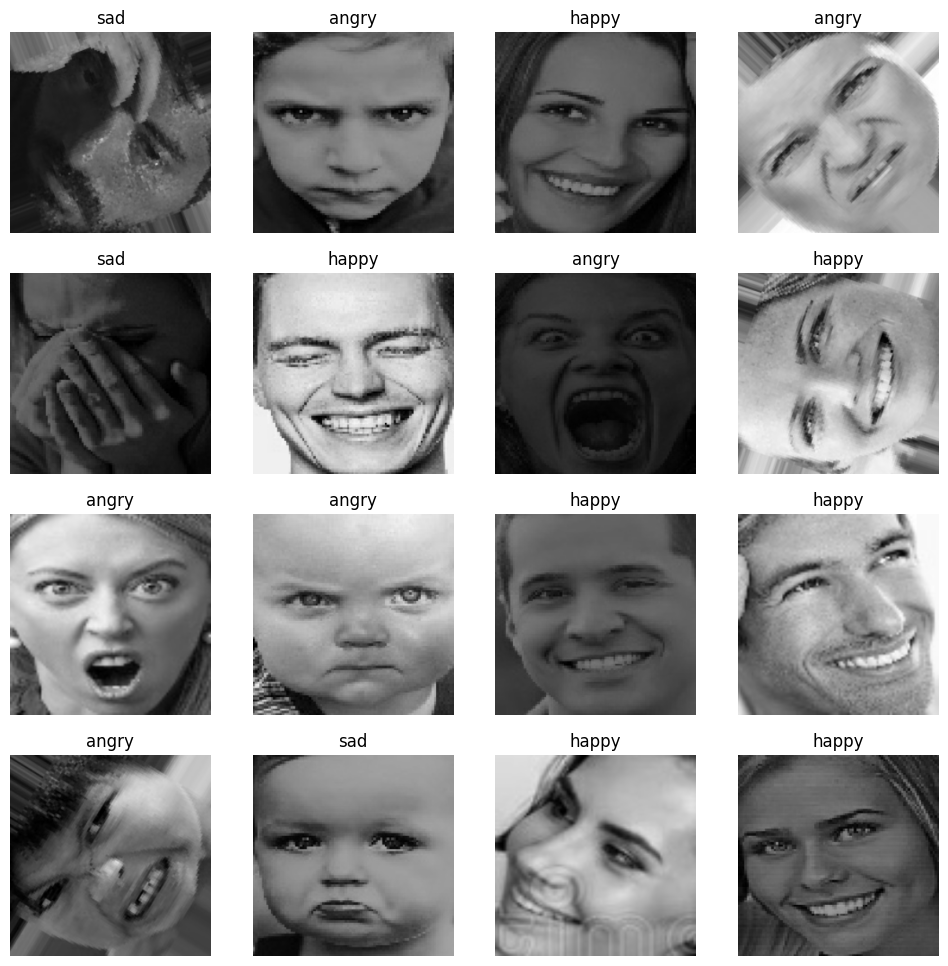

In [6]:
plt.figure(figsize=(12,12))

for images, labels in train_dataset.take(1):
    for i in range(16):
        ax = plt.subplot(4,4, i+1)
        plt.imshow(images[i]/255)
        plt.title(class_names[tf.argmax(labels[i], axis=0).numpy()])
        plt.axis("off")

### Dataset Augmentation

In [71]:
augment_layers = Sequential([
    RandomRotation(factor=(-0.025, 0.025)),
    RandomFlip(mode='horizontal'),
    RandomContrast(factor=0.1)
])

In [72]:
def augment_layer(image, label):
    return augment_layers(image, training=True), label

#### CutMix Data Augmentation

In [76]:

def box(lamda):
  
  r_x = tf.cast(tfp.distributions.Uniform(0, CONFIGURATION["IM_SIZE"]).sample(1)[0], dtype = tf.int32)
  r_y = tf.cast(tfp.distributions.Uniform(0, CONFIGURATION["IM_SIZE"]).sample(1)[0], dtype = tf.int32)

  r_w = tf.cast(CONFIGURATION["IM_SIZE"]*tf.math.sqrt(1-lamda), dtype = tf.int32)
  r_h = tf.cast(CONFIGURATION["IM_SIZE"]*tf.math.sqrt(1-lamda), dtype = tf.int32)

  r_x = tf.clip_by_value(r_x - r_w//2, 0, CONFIGURATION["IM_SIZE"])
  r_y = tf.clip_by_value(r_y - r_h//2, 0, CONFIGURATION["IM_SIZE"])

  x_b_r = tf.clip_by_value(r_x + r_w//2, 0, CONFIGURATION["IM_SIZE"])
  y_b_r = tf.clip_by_value(r_y + r_h//2, 0, CONFIGURATION["IM_SIZE"])

  r_w = x_b_r - r_x
  if(r_w == 0):
    r_w  = 1

  r_h = y_b_r - r_y
  if(r_h == 0):
    r_h = 1

  return r_y, r_x, r_h, r_w

In [77]:

def cutmix(train_dataset_1, train_dataset_2):
  (image_1,label_1), (image_2, label_2) = train_dataset_1, train_dataset_2

  lamda = tfp.distributions.Beta(2,2)
  lamda = lamda.sample(1)[0]
  
  r_y, r_x, r_h, r_w = box(lamda)
  crop_2 = tf.image.crop_to_bounding_box(image_2, r_y, r_x, r_h, r_w)
  pad_2 = tf.image.pad_to_bounding_box(crop_2, r_y, r_x, CONFIGURATION["IM_SIZE"], CONFIGURATION["IM_SIZE"])

  crop_1 = tf.image.crop_to_bounding_box(image_1, r_y, r_x, r_h, r_w)
  pad_1 = tf.image.pad_to_bounding_box(crop_1, r_y, r_x, CONFIGURATION["IM_SIZE"], CONFIGURATION["IM_SIZE"])

  image = image_1 - pad_1 + pad_2

  lamda = tf.cast(1- (r_w*r_h)/(CONFIGURATION["IM_SIZE"]*CONFIGURATION["IM_SIZE"]), dtype = tf.float32)
  label = lamda*tf.cast(label_1, dtype = tf.float32) + (1-lamda)*tf.cast(label_2, dtype = tf.float32)

  return image, label

In [78]:
training_dataset_1 = (
    train_dataset.map(augment_layer, num_parallel_calls=tf.data.AUTOTUNE)
)

training_dataset_2 = (
    train_dataset.map(augment_layer, num_parallel_calls=tf.data.AUTOTUNE)
)

mixed_dataset = tf.data.Dataset.zip((training_dataset_1, training_dataset_2))

### DATASET PREPARATION

In [83]:
training_dataset = (
    mixed_dataset.map(cutmix, num_parallel_calls=tf.data.AUTOTUNE)
    .prefetch(tf.data.AUTOTUNE)
)

In [8]:
validation_dataset = (
    val_dataset.prefetch(tf.data.AUTOTUNE)
)

In [9]:
resize_rescale_layers = Sequential([
    Resizing(CONFIGURATION['IM_SIZE'], CONFIGURATION['IM_SIZE']),
    Rescaling(1./255),
])

In [57]:
lenet_model = Sequential([
    InputLayer(input_shape=(None, None, 3)),
    resize_rescale_layers,
    
    Conv2D(filters=CONFIGURATION['N_FILTERS'], kernel_size=CONFIGURATION['KERNEl_SIZE'], strides=CONFIGURATION['N_STRIDES'], padding='valid', activation="relu", kernel_regularizer=L2(CONFIGURATION['REGULARIZATION_RATE'])),
    BatchNormalization(),
    MaxPool2D(pool_size=CONFIGURATION['POOL_SIZE'], strides=CONFIGURATION['N_STRIDES']*2),
    Dropout(rate=CONFIGURATION['DROPOUT_RATE']),
    
    Conv2D(filters=CONFIGURATION['N_FILTERS']*2 + 4, kernel_size=CONFIGURATION['KERNEl_SIZE'], strides=CONFIGURATION['N_STRIDES'], padding='valid', activation="relu", kernel_regularizer=L2(CONFIGURATION['REGULARIZATION_RATE'])),
    BatchNormalization(),
    MaxPool2D(pool_size=CONFIGURATION['POOL_SIZE'], strides=CONFIGURATION['N_STRIDES']*2),
    
    Flatten(),
    
    Dense(CONFIGURATION['N_DENSE_1'], activation="relu", kernel_regularizer=L2(CONFIGURATION['REGULARIZATION_RATE'])),
    BatchNormalization(),
    Dropout(rate=CONFIGURATION['DROPOUT_RATE']),
    
    Dense(CONFIGURATION['N_DENSE_2'], activation="relu", kernel_regularizer=L2(CONFIGURATION['REGULARIZATION_RATE'])),
    BatchNormalization(),
    
    Dense(CONFIGURATION['NUM_CLASSES'], activation="softmax")

])

lenet_model.summary()

/home/sco/Music/DeepLearningTut/NeuraLearn/.venv/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 254, 254, 6)    │           168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 254, 254, 6)    │            24 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 127, 127, 6)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 127, 127, 6)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 125, 125, 16)   │           880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 125, 125, 16)   │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 62, 62, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 61504)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 100)            │     6,150,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 100)            │           400 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 10)             │         1,010 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 10)             │            40 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 3)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,153,119 (23.47 MB)

 Trainable params: 6,152,855 (23.47 MB)

 Non-trainable params: 264 (1.03 KB)

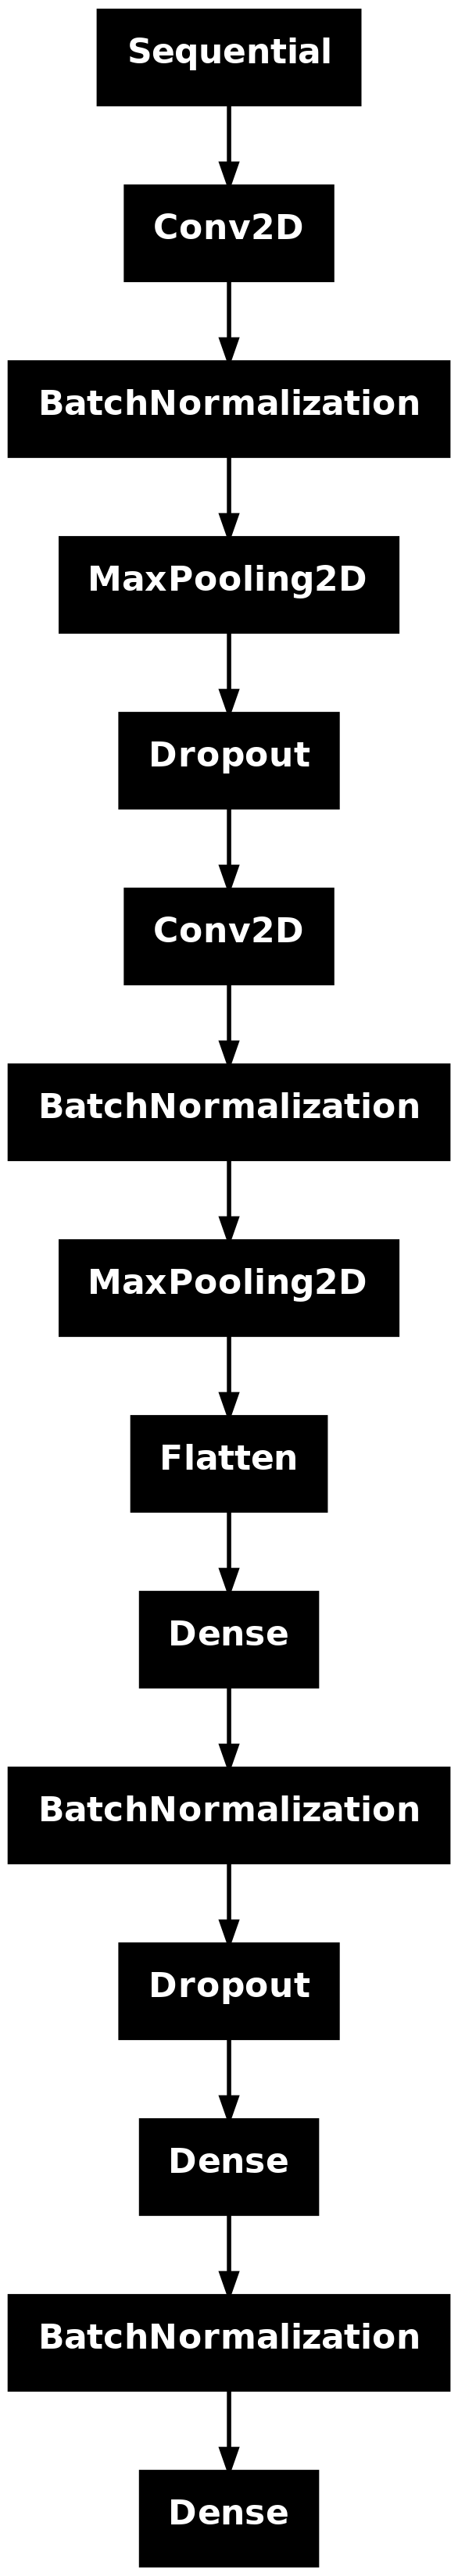

In [58]:
tf.keras.utils.plot_model(
    lenet_model,
    to_file='model.png',
    show_shapes=False,
    show_dtype=False,
    show_layer_names=False,
    rankdir='TB',
    expand_nested=False,
    dpi=200,
    show_layer_activations=False,
    show_trainable=False,
)

In [59]:
loss_function = CategoricalCrossentropy()
# loss_function = SparseCategoricalCrossentropy()

In [60]:
metrics = [CategoricalAccuracy(name="accuracy"), TopKCategoricalAccuracy(k=2, name="top_k_accuracy")]

In [61]:
lenet_model.compile(optimizer=Adam(learning_rate=CONFIGURATION['LEARNING_RATE']), loss=loss_function, metrics=metrics)

In [62]:
history = lenet_model.fit(
    training_dataset,
    validation_data = validation_dataset,
    epochs = CONFIGURATION['N_EPOCHS'],
    verbose=1,
)

Epoch 1/10
213/213 ━━━━━━━━━━━━━━━━━━━━ 218s 1s/step - accuracy: 0.4535 - loss: 1.1195 - top_k_accuracy: 0.7559 - val_accuracy: 0.4416 - val_loss: 1.0961 - val_top_k_accuracy: 0.7739
Epoch 2/10
213/213 ━━━━━━━━━━━━━━━━━━━━ 265s 1s/step - accuracy: 0.5947 - loss: 0.8695 - top_k_accuracy: 0.8504 - val_accuracy: 0.4526 - val_loss: 1.0549 - val_top_k_accuracy: 0.7783
Epoch 3/10
213/213 ━━━━━━━━━━━━━━━━━━━━ 201s 938ms/step - accuracy: 0.6971 - loss: 0.7270 - top_k_accuracy: 0.9083 - val_accuracy: 0.4684 - val_loss: 1.0950 - val_top_k_accuracy: 0.7884
Epoch 4/10
213/213 ━━━━━━━━━━━━━━━━━━━━ 200s 930ms/step - accuracy: 0.7466 - loss: 0.6219 - top_k_accuracy: 0.9300 - val_accuracy: 0.4407 - val_loss: 1.1517 - val_top_k_accuracy: 0.7673
Epoch 5/10
213/213 ━━━━━━━━━━━━━━━━━━━━ 258s 1s/step - accuracy: 0.8047 - loss: 0.5013 - top_k_accuracy: 0.9430 - val_accuracy: 0.4947 - val_loss: 1.2084 - val_top_k_accuracy: 0.7814
Epoch 6/10
213/213 ━━━━━━━━━━━━━━━━━━━━ 249s 1s/step - accuracy: 0.8586 - loss:

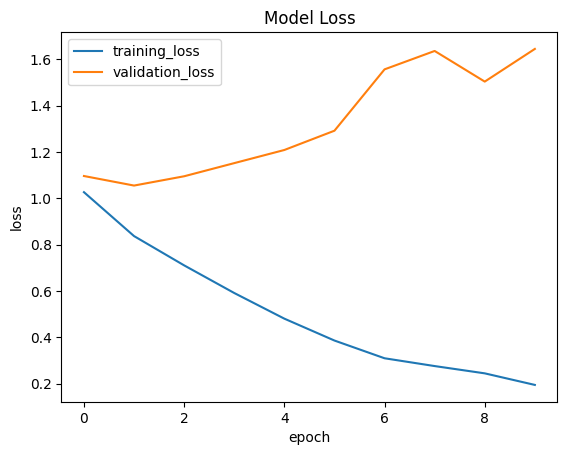

In [63]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['training_loss', 'validation_loss'])
plt.show()

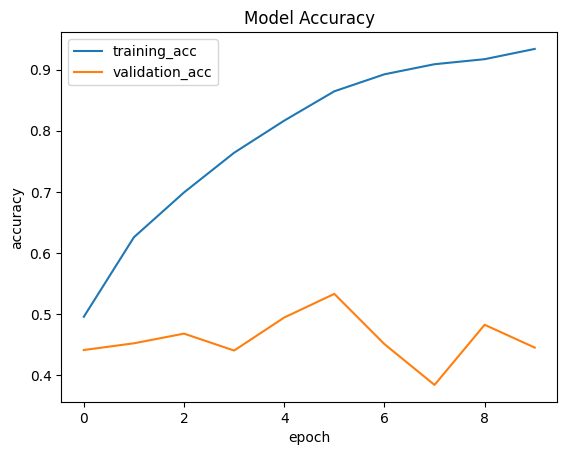

In [64]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['training_acc', 'validation_acc'])
plt.show()

In [65]:
lenet_model.evaluate(validation_dataset)

72/72 ━━━━━━━━━━━━━━━━━━━━ 14s 198ms/step - accuracy: 0.4373 - loss: 1.6739 - top_k_accuracy: 0.7781


[1.644289493560791, 0.4455662965774536, 0.7831431031227112]

In [66]:
test_image = cv2.imread("/home/sco/Music/DeepLearningTut/NeuraLearn/content/dataset/Emotions Dataset/Emotions Dataset/test/angry/33234.jpg_brightness_1.jpg")

im = tf.constant(test_image, dtype=tf.float32)

im = tf.expand_dims(im, axis=0)
print(class_names[tf.argmax(lenet_model(im), axis=-1).numpy()[0]])

angry


2024-07-25 15:05:46.415483: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


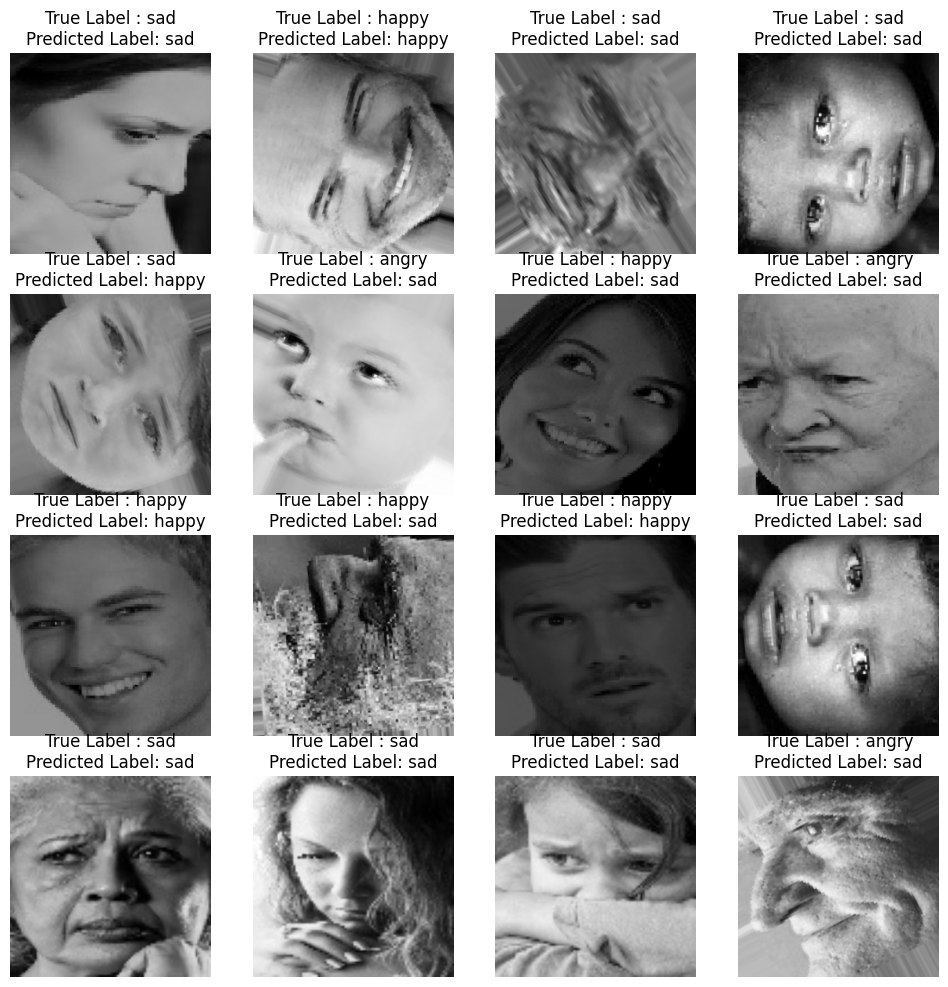

In [67]:
plt.figure(figsize=(12,12))

for images, labels in validation_dataset.take(1):
    for i in range(16):
        ax = plt.subplot(4,4, i+1)
        plt.imshow(images[i]/255)
        plt.title("True Label : " + class_names[tf.argmax(labels[i], axis=0).numpy()] + "\n" + "Predicted Label: " + class_names[tf.argmax(lenet_model(tf.expand_dims(images[i], axis=0)), axis=-1).numpy()[0]])
        plt.axis("off")

In [68]:
labels = []
predicted = []
for im,  label in validation_dataset:
    labels.append(label.numpy())
    predicted.append(lenet_model(im))

2024-07-25 15:06:28.077263: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [69]:
lab = np.concatenate([np.argmax(labels[:-1], axis=-1).flatten(), np.argmax(labels[-1], axis=-1).flatten()])
pred = np.concatenate([np.argmax(predicted[:-1], axis=-1).flatten(), np.argmax(predicted[-1], axis=-1).flatten()])

[[ 84  72 359]
 [ 65 296 645]
 [ 53  69 635]]


Text(0.5, 58.7222222222222, 'Predicted')

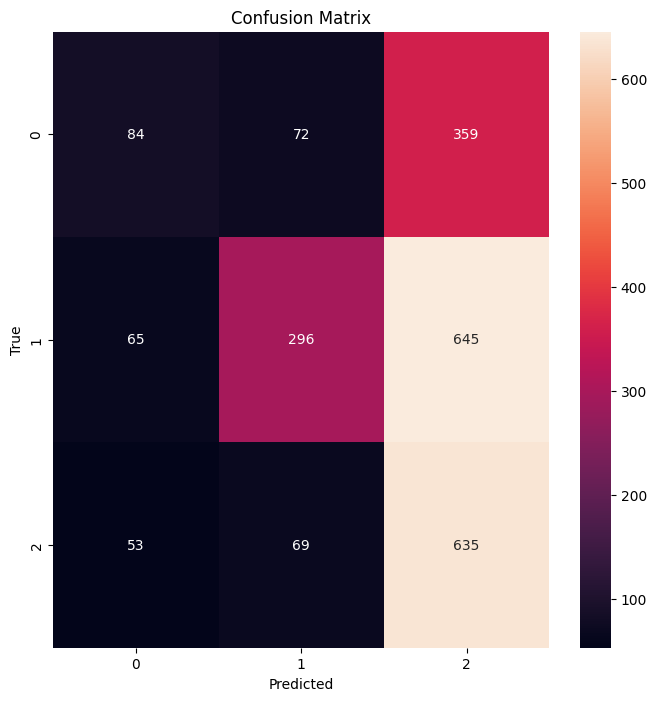

In [70]:
cm = confusion_matrix(lab, pred)
print(cm)

plt.figure(figsize=(8,8))

sns.heatmap(cm, annot=True,  fmt=".4g")
plt.title('Confusion Matrix')
plt.ylabel('True')
plt.xlabel('Predicted')